Данный ноутбук содержит пример выполнения первой лабораторной работы.

In [21]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import pickle
from six.moves.urllib.request import urlretrieve


np.random.seed(0)

# GLOBAL PARAMETERS
# Data
cifar_file_name = "cifar-10-python.tar.gz"
url = 'https://www.cs.toronto.edu/~kriz/'
data_root = '.' # Change me to store data elsewhere
cifar_dir_name = "cifar-10-batches-py"  # where cifar data is stored locally
# Learning
alpha = 0.5  # learning rate
num_epochs = 500  # number of learning epochs 
batch_size = 1000  # mini-batch size for gradient descent

Определим функции для загрузки данных с удаленного сервера и разархивации их в локальный каталог.

In [11]:
def maybe_download():
    """Download the file if it does not exist."""

    dest_file_name = os.path.join(data_root, cifar_file_name)

    if not os.path.exists(dest_file_name):
        urlretrieve(url + cifar_file_name, dest_file_name)

    statinfo = os.stat(dest_file_name)
    print("File ", dest_file_name, " size : ", statinfo.st_size, " bytes.")

    return dest_file_name


def maybe_extract(file_name):
    """Extract compressed file if is was not uncomressed before."""

    tar = tarfile.open(file_name)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()

    dest_dir_name = os.path.join(data_root, cifar_dir_name)
    if not os.path.exists(dest_dir_name):
        raise Exception("No data directory. Check that archive with data exists, not corrupted and contains ",
                        cifar_dir_name, " inside.")

    return dest_dir_name


data_file_name = maybe_download()
data_dir_name = maybe_extract(data_file_name)

File  .\cifar-10-python.tar.gz  size :  170498071  bytes.


## Предобработка данных.

После разархивации получим набор двоичных фалов, в которых хранятся данные CIFAR. 

Тренировочная выборка разбита на 5 файлов (data_batch_1, ..., data_batch_5). Прочтем все эти файлы и объединим данные из них в один массив. Затем загрузим тестовую выборку.

In [22]:
# load train and test data
train_batches = ["data_batch_1",
                 "data_batch_2",
                 "data_batch_3",
                 "data_batch_4",
                 "data_batch_5",
                ]


train_labels = []
train_data = []
for train_batch in train_batches:
    path_to_batch = data_dir_name + "/" + train_batch
    print("Loading ", path_to_batch, "...")
    batch = pickle.load(open(path_to_batch, "rb"), encoding="bytes")
    # batch is a dictionary, dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
    # let's store data and labels for all batches in a separate arrays
    train_labels.extend(batch[b"labels"])
    train_data.extend(batch[b"data"])
    print("Done.")
    
# also load titles for labels
raw = pickle.load(open(data_dir_name + "/batches.meta", "rb"))
class_names = [x for x in raw["label_names"]]

print(class_names)

Loading  .\cifar-10-batches-py/data_batch_1 ...
Done.
Loading  .\cifar-10-batches-py/data_batch_2 ...
Done.
Loading  .\cifar-10-batches-py/data_batch_3 ...
Done.
Loading  .\cifar-10-batches-py/data_batch_4 ...
Done.
Loading  .\cifar-10-batches-py/data_batch_5 ...
Done.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


frog


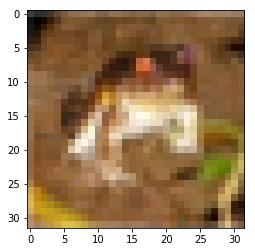

In [13]:
# let's have a look at a sample image
sample_no = 0
sample_data = train_data[sample_no]

sample_image = np.reshape(sample_data, [3, 32, 32])
sample_image = np.swapaxes(sample_image, 0, 2)
sample_image = np.transpose(sample_image, [1, 0, 2])

matplotlib.pyplot.imshow(sample_image)
print(class_names[train_labels[sample_no]])

In [17]:
def preprocess_data(X, m, v):
    if not m.any():
        m = np.mean(X, axis=0)
    if not v.any():
        v = np.var(X, axis=0)
    X = (X - m) / v
    return X, m, v


def preprocess_labels(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt


def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))


def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)


def forward(theta_mat, X):
    probs = np.array([h(theta_mat[:, i], X) for i in range(0, theta_mat.shape[1])])
    return probs.transpose()


def derivative(X, y_gt, y_pred):
    """Derivative of cross-entropy loss over parameters of one logistic classifier."""
    return np.dot(y_pred - y_gt, X) / len(y_gt)

def backward(X, y_gt, theta):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    d_theta = np.zeros([num_features, num_classes])
    y_pred = forward(theta, X)
    for class_no in range(0, num_classes):
        d_theta[:, class_no] = derivative(X, y_gt[:, class_no], y_pred[:, class_no])
    return d_theta

In [23]:
# Now let's train a very simple baseline classification model - one-vs-all multiclass logistic regression
num_classes = len(class_names)

train_data = np.array(train_data, dtype=float)
train_labels = np.array(train_labels)

print("Data shape : ", train_data.shape)
print("Labels shape : ", train_labels.shape)

num_features = train_data.shape[1]
num_samples = train_data.shape[0]
num_train_samples = 40000

p = np.random.permutation(num_samples)
x_train = train_data[p[0:num_train_samples], :]
y_train = train_labels[p[0:num_train_samples]]

x_val = train_data[p[num_train_samples:], :]
val_labels = train_labels[p[num_train_samples:]]
train_labels = y_train

x_train, m_train, v_train = preprocess_data(x_train, np.array([]), np.array([]))
y_train = preprocess_labels(y_train, num_classes)

x_val, _, _ = preprocess_data(x_val, m_train, v_train)

theta = np.random.randn(num_features, num_classes)

num_batches = num_train_samples // batch_size

y_pred = forward(theta, x_train)
loss_val = loss(y_train, y_pred)
print("Initial loss :", loss_val)

for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('Epoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no+1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, theta)
        theta = theta - alpha*d_theta

    # if np.mod(i, num_epochs // 10) == 0:
    pred_train_probs = forward(theta, x_train)
    pred_train_labels = np.argmax(pred_train_probs, axis=1)
    loss_val = loss(y_train, pred_train_probs)

    pred_val_labels = np.argmax(forward(theta, x_val), axis=1)
    print("\nLoss :", loss_val,
          " Train accuracy : ", (1-np.mean(pred_train_labels != train_labels))*100,
          " Validation accuracy : ", (1 - np.mean(pred_val_labels != val_labels)) * 100)

Data shape :  (50000, 3072)
Labels shape :  (50000,)
Initial loss : 7.86819617587
Epoch 0/500 ...........
Loss : 7.51806671763  Train accuracy :  11.505  Validation accuracy :  11.61
Epoch 1/500 ...........
Loss : 7.37234761403  Train accuracy :  12.7175  Validation accuracy :  12.65
Epoch 2/500 ...........
Loss : 7.29077459673  Train accuracy :  13.7275  Validation accuracy :  13.58
Epoch 3/500 ...........
Loss : 7.23550456451  Train accuracy :  14.7  Validation accuracy :  14.54
Epoch 4/500 ...........
Loss : 7.19446975983  Train accuracy :  15.67  Validation accuracy :  15.58
Epoch 5/500 ...........
Loss : 7.16229564872  Train accuracy :  16.52  Validation accuracy :  16.4
Epoch 6/500 ...........
Loss : 7.13620079394  Train accuracy :  17.25  Validation accuracy :  17.46
Epoch 7/500 ...........
Loss : 7.11448333236  Train accuracy :  17.895  Validation accuracy :  18.13
Epoch 8/500 ...........
Loss : 7.09602081629  Train accuracy :  18.56  Validation accuracy :  18.94
Epoch 9/500 ..

Epoch 80/500 ...........
Loss : 6.84415779592  Train accuracy :  30.4225  Validation accuracy :  30.62
Epoch 81/500 ...........
Loss : 6.84309559567  Train accuracy :  30.5175  Validation accuracy :  30.66
Epoch 82/500 ...........
Loss : 6.84205481269  Train accuracy :  30.6025  Validation accuracy :  30.7
Epoch 83/500 ...........
Loss : 6.84102948716  Train accuracy :  30.66  Validation accuracy :  30.73
Epoch 84/500 ...........
Loss : 6.84003146247  Train accuracy :  30.7425  Validation accuracy :  30.78
Epoch 85/500 ...........
Loss : 6.83903147227  Train accuracy :  30.81  Validation accuracy :  30.84
Epoch 86/500 ...........
Loss : 6.83805157938  Train accuracy :  30.87  Validation accuracy :  30.93
Epoch 87/500 ...........
Loss : 6.83708968273  Train accuracy :  30.965  Validation accuracy :  31.0
Epoch 88/500 ...........
Loss : 6.83613805605  Train accuracy :  31.0075  Validation accuracy :  31.02
Epoch 89/500 ...........
Loss : 6.83520419945  Train accuracy :  31.0725  Validati

Epoch 160/500 ...........
Loss : 6.79021897062  Train accuracy :  33.955  Validation accuracy :  33.54
Epoch 161/500 ...........
Loss : 6.78977533271  Train accuracy :  33.9875  Validation accuracy :  33.54
Epoch 162/500 ...........
Loss : 6.78933649135  Train accuracy :  34.005  Validation accuracy :  33.6
Epoch 163/500 ...........
Loss : 6.78890174574  Train accuracy :  34.025  Validation accuracy :  33.64
Epoch 164/500 ...........
Loss : 6.78847510405  Train accuracy :  34.0425  Validation accuracy :  33.64
Epoch 165/500 ...........
Loss : 6.78805016246  Train accuracy :  34.1025  Validation accuracy :  33.69
Epoch 166/500 ...........
Loss : 6.78763904807  Train accuracy :  34.1125  Validation accuracy :  33.71
Epoch 167/500 ...........
Loss : 6.78720162821  Train accuracy :  34.1425  Validation accuracy :  33.73
Epoch 168/500 ...........
Loss : 6.78678549207  Train accuracy :  34.22  Validation accuracy :  33.79
Epoch 169/500 ...........
Loss : 6.78637244977  Train accuracy :  34.2

Epoch 240/500 ...........
Loss : 6.76323741423  Train accuracy :  35.75  Validation accuracy :  35.25
Epoch 241/500 ...........
Loss : 6.76298026885  Train accuracy :  35.785  Validation accuracy :  35.22
Epoch 242/500 ...........
Loss : 6.76272393436  Train accuracy :  35.8025  Validation accuracy :  35.26
Epoch 243/500 ...........
Loss : 6.76246663014  Train accuracy :  35.7975  Validation accuracy :  35.27
Epoch 244/500 ...........
Loss : 6.76221596526  Train accuracy :  35.8225  Validation accuracy :  35.31
Epoch 245/500 ...........
Loss : 6.76196222417  Train accuracy :  35.825  Validation accuracy :  35.27
Epoch 246/500 ...........
Loss : 6.7617161788  Train accuracy :  35.8525  Validation accuracy :  35.27
Epoch 247/500 ...........
Loss : 6.76145829621  Train accuracy :  35.8725  Validation accuracy :  35.24
Epoch 248/500 ...........
Loss : 6.76120921332  Train accuracy :  35.88  Validation accuracy :  35.24
Epoch 249/500 ...........
Loss : 6.76096604225  Train accuracy :  35.88

Epoch 320/500 ...........
Loss : 6.74623745065  Train accuracy :  37.075  Validation accuracy :  35.98
Epoch 321/500 ...........
Loss : 6.74606260343  Train accuracy :  37.0975  Validation accuracy :  35.96
Epoch 322/500 ...........
Loss : 6.74588832447  Train accuracy :  37.12  Validation accuracy :  35.98
Epoch 323/500 ...........
Loss : 6.74571626802  Train accuracy :  37.11  Validation accuracy :  36.0
Epoch 324/500 ...........
Loss : 6.74554642706  Train accuracy :  37.145  Validation accuracy :  35.94
Epoch 325/500 ...........
Loss : 6.74537068311  Train accuracy :  37.135  Validation accuracy :  35.92
Epoch 326/500 ...........
Loss : 6.74520440166  Train accuracy :  37.16  Validation accuracy :  35.92
Epoch 327/500 ...........
Loss : 6.74503121101  Train accuracy :  37.1575  Validation accuracy :  35.96
Epoch 328/500 ...........
Loss : 6.74486217465  Train accuracy :  37.1875  Validation accuracy :  35.93
Epoch 329/500 ...........
Loss : 6.74469183164  Train accuracy :  37.215  

Epoch 400/500 ...........
Loss : 6.73425857587  Train accuracy :  37.965  Validation accuracy :  36.45
Epoch 401/500 ...........
Loss : 6.7341301698  Train accuracy :  37.9725  Validation accuracy :  36.44
Epoch 402/500 ...........
Loss : 6.73400211742  Train accuracy :  37.97  Validation accuracy :  36.44
Epoch 403/500 ...........
Loss : 6.73387295723  Train accuracy :  37.9675  Validation accuracy :  36.45
Epoch 404/500 ...........
Loss : 6.73374756348  Train accuracy :  37.9725  Validation accuracy :  36.49
Epoch 405/500 ...........
Loss : 6.7336216534  Train accuracy :  37.9825  Validation accuracy :  36.49
Epoch 406/500 ...........
Loss : 6.73349531961  Train accuracy :  38.01  Validation accuracy :  36.49
Epoch 407/500 ...........
Loss : 6.73336722895  Train accuracy :  38.015  Validation accuracy :  36.52
Epoch 408/500 ...........
Loss : 6.73324539361  Train accuracy :  38.02  Validation accuracy :  36.54
Epoch 409/500 ...........
Loss : 6.73311830916  Train accuracy :  38.0475 

Epoch 480/500 ...........
Loss : 6.72520587607  Train accuracy :  38.7025  Validation accuracy :  36.7
Epoch 481/500 ...........
Loss : 6.7251226651  Train accuracy :  38.6925  Validation accuracy :  36.72
Epoch 482/500 ...........
Loss : 6.7250125444  Train accuracy :  38.7075  Validation accuracy :  36.74
Epoch 483/500 ...........
Loss : 6.72491123285  Train accuracy :  38.7325  Validation accuracy :  36.74
Epoch 484/500 ...........
Loss : 6.72480933524  Train accuracy :  38.73  Validation accuracy :  36.81
Epoch 485/500 ...........
Loss : 6.72470999594  Train accuracy :  38.725  Validation accuracy :  36.83
Epoch 486/500 ...........
Loss : 6.72461121734  Train accuracy :  38.7375  Validation accuracy :  36.83
Epoch 487/500 ...........
Loss : 6.72451725467  Train accuracy :  38.73  Validation accuracy :  36.74
Epoch 488/500 ...........
Loss : 6.72441993992  Train accuracy :  38.74  Validation accuracy :  36.81
Epoch 489/500 ...........
Loss : 6.72431783627  Train accuracy :  38.745  

Оценим точность на тестовой выборке.

In [25]:
test_samples = pickle.load(open(data_dir_name + "/test_batch", "rb"), encoding="bytes")
test_labels = test_samples[b"labels"]
test_data = test_samples[b"data"]
x_test, _, _ = preprocess_data(test_data, m_train, v_train)
predictions = np.argmax(forward(theta, x_test), axis=1)
print("\nTest accuracy : ", 100*np.mean(predictions == test_labels))


Test accuracy :  36.75
